<a href="https://colab.research.google.com/github/marcellosusanto11/predict_flight_cross_sell_hotel/blob/master/full_kernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
# Set working directory
%cd drive/My\ Drive/Colab\ Notebooks/Datavidia/

/content/drive/My Drive/Colab Notebooks/Datavidia


In [3]:
# Install package
!pip install h2o

     |████████████████████████████████| 126.2MB 104kB/s 
  Created wheel for h2o: filename=h2o-3.28.1.2-py2.py3-none-any.whl size=126306247 sha256=999fbdf4e13c0b21329e8445c43500ee76e53b0fcd47210ec781c3697fa3203c
  Stored in directory: /root/.cache/pip/wheels/18/3c/ca/07a89a0183a77f66ad2fac339e16ba5f943dde887e9a1cac18
Successfully built h2o


In [0]:
# Setting general package
import pandas as pd
import pandas_profiling as pp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

from matplotlib.pylab import rcParams
# For every plotting cell use this
# fig, axes = plt.subplots()
rcParams['figure.figsize'] = [10,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [0]:
# Load dataset
df_train = pd.read_csv("Data/flight.csv")
df_hotel = pd.read_csv("Data/hotel.csv")
df_test = pd.read_csv("Data/test.csv")

## Predict Flight Cross Sell Hotel
Upsell and Cros-sell are marketing term that are beneficial when done properly, providing maximum value to customers and increasing revenue without the recurring cost of many marketing channels. Upselling is the practice of encouraging customers to purchase a comparable higher-end product than the one in question. cross-selling invites customers to buy related or complementary items

We have a dataset which each row consist of detailed information about each flight transaction from Jakarta to Bali. The dataset recorded from 1 January 2018 to 31 December 2018. Using this dataset we want to analyze and predict which transaction have a potential to book a hotel as well, so we can make a marketing strategy to promote the right hotel focusing on the potential customer.

In [6]:
# Overview dataset train
df_train.head()

,account_id,order_id,member_duration_days,gender,trip,service_class,price,is_tx_promo,no_of_seats,airlines_name,route,hotel_id,visited_city,log_transaction
0,912aa410a02cd7e1bab414214a7005c0,5c6f39c690f23650d3cde28e5b51c908,566.0000,M,trip,ECONOMY,885898.0000,NO,1.0000,33199710eb822fbcfd0dc793f4788d30,CGK - DPS,None,"'['Semarang', 'Jakarta', 'Medan', 'Bali']'","'[545203.03, 918492.11, 1774241.4, 885898.0]'"
1,d64a90a618202a5e8b25d8539377f3ca,5cbef2b87f51c18bf399d11bfe495a46,607.0000,M,trip,ECONOMY,2139751.2500,NO,2.0000,0a102015e48c1f68e121acc99fca9a05,CGK - DPS,None,"'['Jakarta', 'Medan', 'Bali']'","'[555476.36, 2422826.84, 7398697.64, 7930866.8..."
2,1a42ac02bcb4a902973123323f84da55,38fc35a1e62384012a358ab1fbd5ad03,648.0000,F,trip,ECONOMY,2695550.0000,NO,1.0000,0a102015e48c1f68e121acc99fca9a05,CGK - DPS,None,"'['Semarang', 'Jakarta', 'Medan', 'Bali']'","'[7328957.45, 7027662.34, 1933360.88, 3461836...."
3,92cddd64d4be4dec6dfbcc0c50e902f4,c7f54cb748828b4413e02dea2758faf6,418.0000,F,trip,ECONOMY,1146665.0000,NO,1.0000,0a102015e48c1f68e121acc99fca9a05,CGK - DPS,None,"'['Jogjakarta', 'Bali', 'Jakarta', 'Medan']'","'[5243631.69, 2474344.48, 1146665.0]'"
4,bf637abc47ea93bad22264f4956d67f6,dec228e4d2b6023c9f1fe9cfe9c451bf,537.0000,F,trip,ECONOMY,1131032.5000,NO,1.0000,6c483c0812c96f8ec43bb0ff76eaf716,CGK - DPS,None,"'['Jakarta', 'Bali', 'Medan', 'Jogjakarta', 'S...","'[9808972.98, 9628619.79, 6712680.0, 5034510.0..."


- There are 3 variables that have been hashed : account_id, order_id, and airlines_name
- We can see that variable visited_city and log_transaction values is a list. So we need to do some feature transformation to extract information from these variables
- If a flight transaction don't book a hotel, the value of variable hotel_id will be None. So we can make a  categorical response variable is_cross_sell from this variable

In [7]:
# Overview dataset hotel
df_hotel.head()

,hotel_id,starRating,city,free_wifi,pool_access,free_breakfast
0,e2733e84102226acf6b53bffd2e60cf8,0.0000,bali,YES,NO,NO
1,9f9de5df06d64ada1026e930687a87e4,0.0000,bali,YES,NO,NO
2,3cf6774fb4dc331bb49e7a959b74a67e,0.0000,bali,YES,NO,NO
3,eca261898220478834072b0c753a5229,0.0000,bali,YES,NO,NO
4,c21f400013fa4f244a7168a3c155b8b5,0.0000,bali,YES,NO,NO


## Data Preprocessing
In this section we will check wether he dataset that will be used have any missing values and we will also do some quality check based on the variable explanation in 'Data Dictionary.pdf'. Beside that we will make new variable using existing variable in the dataset to support our analysis

In [8]:
# Check missing values in train and test dataset
df_full = pd.concat([df_train.drop(columns=['hotel_id']), df_test])
df_full.isnull().sum()

account_id              0
order_id                0
member_duration_days    0
gender                  0
trip                    0
service_class           0
price                   0
is_tx_promo             0
no_of_seats             0
airlines_name           0
route                   0
visited_city            0
log_transaction         0
dtype: int64

In [9]:
# Check missing values in hotel dataset
df_hotel.isnull().sum()

hotel_id          0
starRating        0
city              0
free_wifi         0
pool_access       0
free_breakfast    0
dtype: int64

**Conclusion** : We can see that the dataset have no missing values
<br> After this we eill count how many unique value for each variable in our dataset

In [10]:
# Count unique value in train dataset
N = len(df_train)
for var in df_train.columns :
    n_unique = df_train[var].nunique()
    print(var,':',n_unique,'(',n_unique/N,")")

account_id : 74796 ( 0.6341546131280417 )
order_id : 117946 ( 1.0 )
member_duration_days : 2299 ( 0.019491970901938174 )
gender : 3 ( 2.5435368728061996e-05 )
trip : 3 ( 2.5435368728061996e-05 )
service_class : 2 ( 1.6956912485374663e-05 )
price : 13724 ( 0.11635833347464093 )
is_tx_promo : 2 ( 1.6956912485374663e-05 )
no_of_seats : 11 ( 9.326301866956065e-05 )
airlines_name : 8 ( 6.782764994149865e-05 )
route : 1 ( 8.478456242687331e-06 )
hotel_id : 676 ( 0.0057314364200566365 )
visited_city : 8 ( 6.782764994149865e-05 )
log_transaction : 117946 ( 1.0 )


- Variable route consist of single value so we will drop it
- Variable gender and trip should only have 2 unique values (M/F and trip/roundtrip), so we will investigate these variables further
- Variable account_id have an uniqe value proporsition 63% of the dataset. This means one account can have many transaction in this dataset

In [11]:
# Check unique value proposition of variable gender
print('On train dataset')
print(df_train['gender'].value_counts())
print('\nOn test dataset')
print(df_test['gender'].value_counts())

On train dataset
M       61036
F       56886
None       24
Name: gender, dtype: int64

On test dataset
M    5147
F    4853
Name: gender, dtype: int64


There are 'None' value in variable gender that maybe caused by data inputation error. There is no possbile way for us to determin the correct value for 'None' so we will drop the row with 'None' value

In [0]:
# Clean variable gender
df_train = df_train[~(df_train['gender']=='None')]

In [13]:
# Check unique value proposition of variable trip
print('On train dataset')
print(df_train['trip'].value_counts())
print('\nOn test dataset')
print(df_test['trip'].value_counts())

On train dataset
trip         99126
roundtrip    13814
round         4982
Name: trip, dtype: int64

On test dataset
trip         8399
roundtrip    1253
round         348
Name: trip, dtype: int64


We can see that variable trip have value 'round'. This is weird because as we know there are only two option when we want to book a flight, either we buy a single trip ticket (trip) or roundtrip. Logically we can assume that 'round' have a same meaning as 'trip' because we only have one route in this dataset. So we will change the value 'round' into 'trip

In [0]:
# Clean variabel trip
df_train['trip'] = df_train['trip'].replace({'round':'trip'})
df_test['trip'] = df_test['trip'].replace({'round':'trip'})

Then we will make variable is_cross_sell with the same format and meaning as the submission 

In [0]:
# Make variable is_cross_sell
df_train['is_cross_sell'] = ~(df_train['hotel_id'] == 'None')
df_train['is_cross_sell'] = df_train['is_cross_sell'].replace({True:'yes', False:'no'})

Variable visited_city is a list that contain all the city that have been visited by each custome account. So from this variable we will make variable total_city that represent how many city that have been visited

In [0]:
# Make variable total_city
import ast 
df_train['total_city'] = df_train.apply(lambda x: len(ast.literal_eval(x['visited_city'].strip("'"))), axis=1)
df_test['total_city'] = df_train.apply(lambda x: len(ast.literal_eval(x['visited_city'].strip("'"))), axis=1)

Variable log_transaction contains all the historical flight payment for each customer account. From this variable we will make many aggregated variables based on customer account such as :
- mean_transaction : Average of the payment
- median_transaction : Median of the payment
- last_transaction : Last payment

In [0]:
# Make aggreagated variables from log_transaction
def make_var_log_transaction(df) :
    import ast 
    df['mean_transaction'] = df.apply(lambda x: np.mean(ast.literal_eval(ast.literal_eval(x['log_transaction']))), axis=1)
    df['median_transaction'] = df.apply(lambda x: np.median(ast.literal_eval(ast.literal_eval(x['log_transaction']))), axis=1)
    df['last_price'] = df.apply(lambda x: ast.literal_eval(ast.literal_eval(x['log_transaction']))[-2], axis=1)
    
    return df

df_train = make_var_log_transaction(df_train)
df_test = make_var_log_transaction(df_test)

Variable price represent the total payment for each flight order. From this variable we will estimate the single ticket price for each flight order with these formula :
- If 'trip' then single_price = price/no_of_seats
- If 'roundtrip' then single_price = price/(2*no_of_seats)

In [0]:
# Make variable single_price
def make_single_price(price, member, trip) :
    if trip == 'roundtrip' :
        new_price = price/(2*member)
    else :
        new_price = price/member
    return new_price

df_train['single_price'] = df_train.apply(lambda x: make_single_price(x['price'], x['no_of_seats'], x['trip']), axis=1)
df_test['single_price'] = df_test.apply(lambda x: make_single_price(x['price'], x['no_of_seats'], x['trip']), axis=1)

## Exploratory Data Analysis
In this section we will find the connection between the predictor variables and the response variable which is is_cross_sell. Also we will try to find a pattern in the dataset that can help us on feature engineering or modelling process

First we will count the proportion of variable respon is_cross_sell

In [19]:
# Proportion of variable is_cross_sell
df_train['is_cross_sell'].value_counts() / len(df_train) * 100

no    94.2793
yes    5.7207
Name: is_cross_sell, dtype: float64

We can see that the response variable is imbalanced with the proportion of 'no':'yes' is 95:5. Next we will calculate the descriptive statstics of the dataset


In [20]:
# Descriptive statistics dataset
df_train.describe()

,member_duration_days,price,no_of_seats,total_city,mean_transaction,median_transaction,last_price,single_price
count,117922.0000,117922.0000,117922.0000,117922.0000,117922.0000,117922.0000,117922.0000,117922.0000
mean,955.4862,2672943.2468,1.6887,3.5495,4025460.6498,3678702.0650,4095683.0396,1448177.4833
std,565.2859,2449444.4539,1.1338,0.8301,1504557.4596,1883144.2070,2967393.2375,638500.6948
min,329.0000,406952.0000,1.0000,3.0000,387336.4967,-13503.1000,-40509.3000,291356.0000
25%,537.0000,1282710.0000,1.0000,3.0000,2913439.6607,2145429.1663,1638051.2650,1009578.7910
50%,678.0000,1987440.0000,1.0000,3.0000,3932382.0360,3304370.8400,3186874.2150,1257360.0000
75%,1341.0000,2974400.0000,2.0000,4.0000,4976089.3870,4920962.0013,6349604.7000,1642680.0000
max,2720.0000,59036432.0000,11.0000,5.0000,21198284.3167,29882580.0000,56819490.0000,16196115.0000


- There is an indication that the variable member_duration_days have a skewed distribution
- Variable median_transaction and last_price have a negative value as their minimum value. This is weird
- The maximum value of price variable is too high (single price have maximum value of 16 million). This is also weird

So we will make a pairplot to see the connection between continuous variable and their distribution

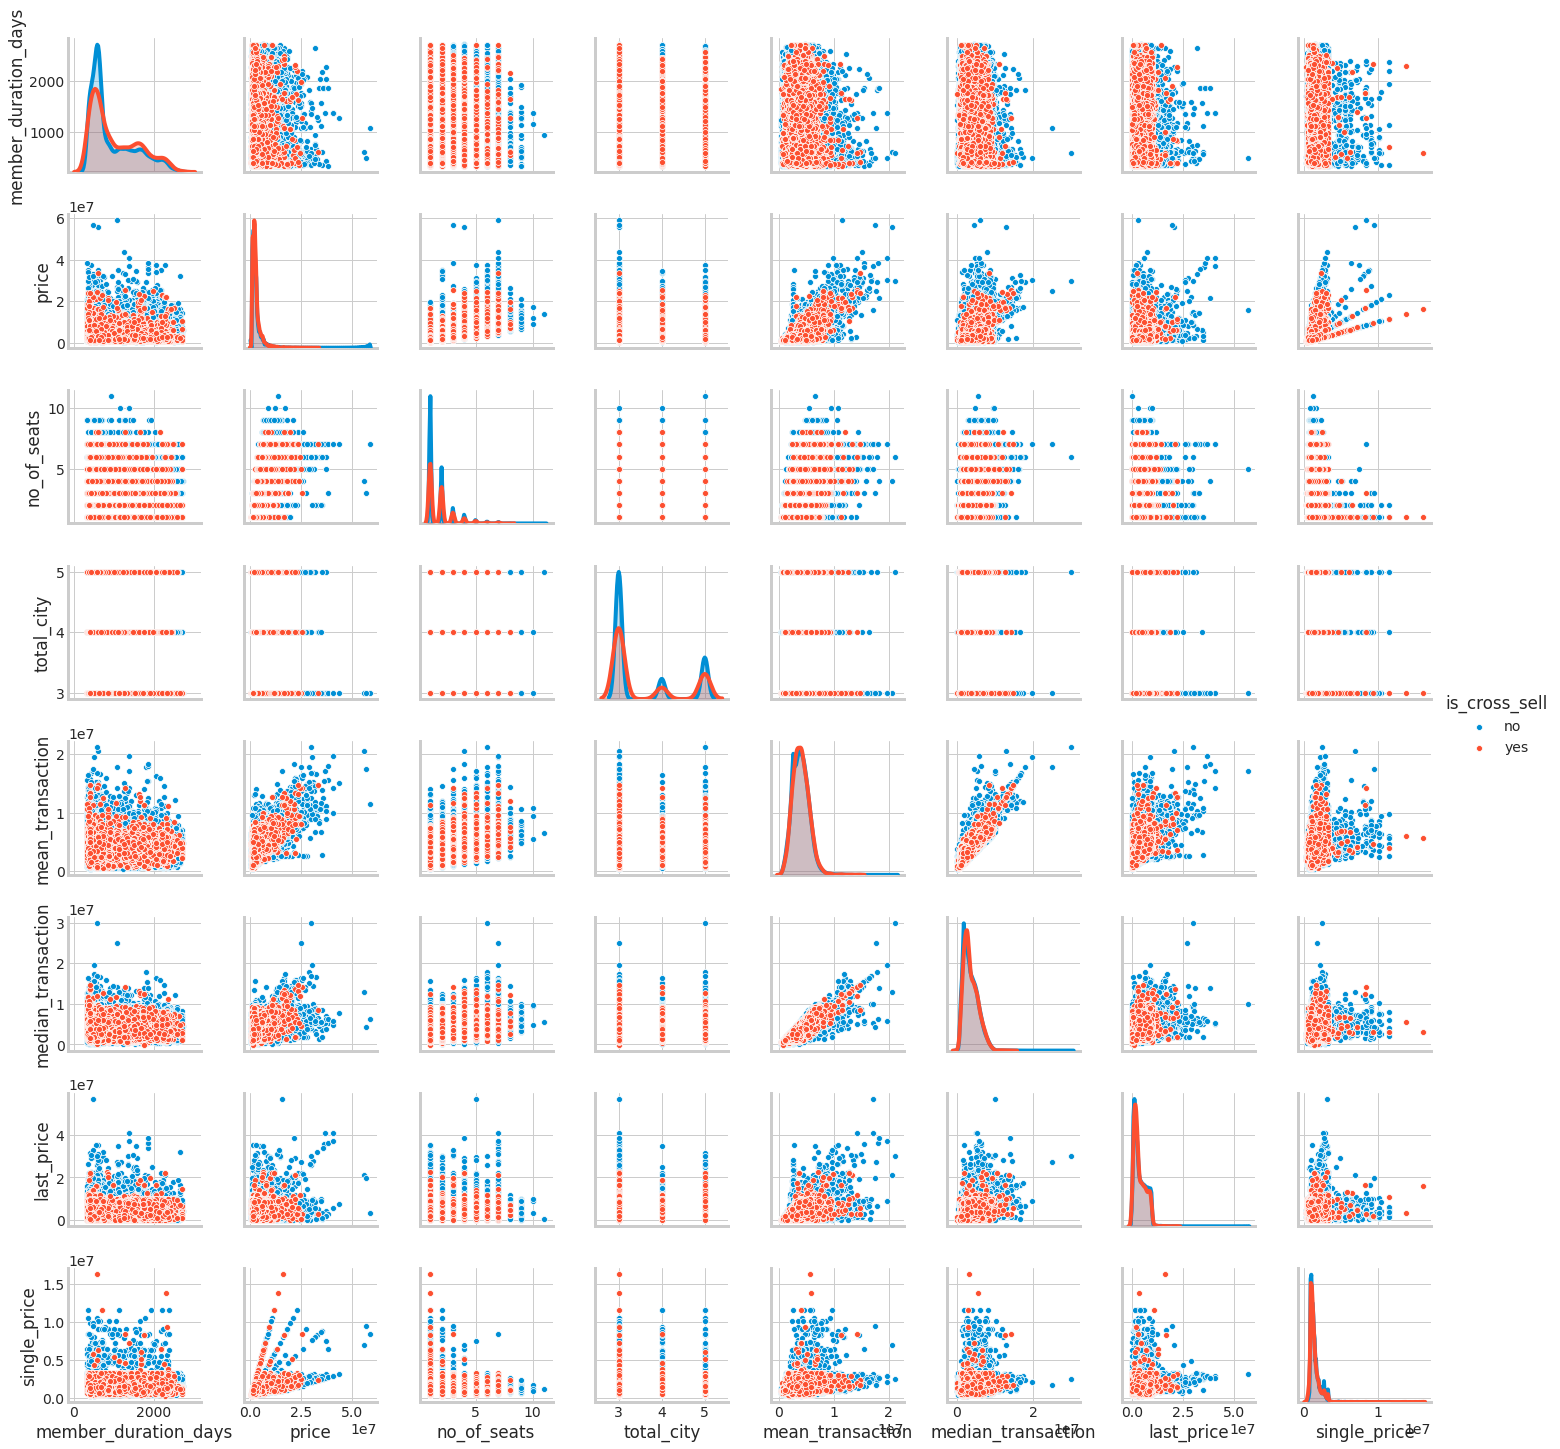

In [21]:
# Plot setting
rcParams['figure.figsize'] = [10,10]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')

# Plot preparation
df_plot = df_train.copy()

# Make the pairplot
sns.pairplot(data=df_plot, hue='is_cross_sell')

From the graph above we can conclude that :
- From the distribution plot, we can see that there are no significance difference between is_cross_sell=='yes' and 'no' for each continuous variable. But in variable member_duration_days the peak proposition of is_cross_sell=='no' is higher
- From the scatterplot of member_duration_days and single_price we can see thath the observation of is_cross_sell=='yes' are assembled below certin value of single_price

Next we will investigate variable median_transaction and last_price

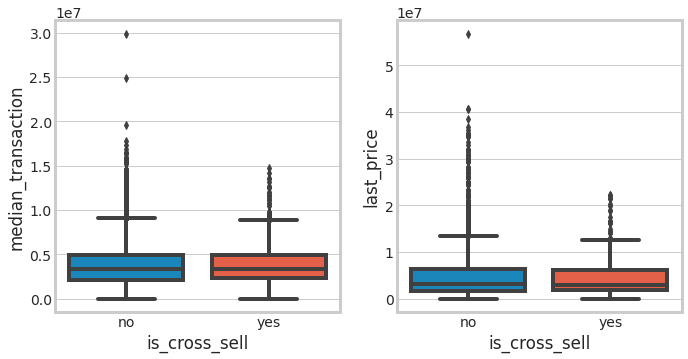

In [22]:
# Plot setting
rcParams['figure.figsize'] = [10,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,2)

# Plot preparation
list_var = ['median_transaction', 'last_price']

# Boxplot of median_transaction and last_price
for i in range(len(list_var)) :
    sns.boxplot(data=df_train, y=list_var[i], x='is_cross_sell', ax=ax[i])

We can see that both of these variables have the same distribution based on is_cross_sell, however for the case where is_cross_sell=='no' both variable have more outlier

In [23]:
# Percentile of both variables
list_per = [1,2,3,4,5,6,7,8,9,10]
list_var = ['last_price', 'price']

for var in list_var :
    print('Persentil dari',var)
    for per in list_per :
        print(str(per)+'% Persentil :',np.percentile(df_train[var], per))
    print('')

Persentil dari last_price
1% Persentil : 162142.1968
2% Persentil : 327085.4186
3% Persentil : 488677.89209999994
4% Persentil : 642517.9447999999
5% Persentil : 797210.288
6% Persentil : 874149.7036
7% Persentil : 902798.0
8% Persentil : 932542.0
9% Persentil : 951639.0
10% Persentil : 983449.4870000001

Persentil dari price
1% Persentil : 846859.0
2% Persentil : 877448.0
3% Persentil : 892489.0
4% Persentil : 902798.0
5% Persentil : 927990.83
6% Persentil : 934739.0
7% Persentil : 940316.0
8% Persentil : 951639.0
9% Persentil : 971919.0
10% Persentil : 988819.0



We can see that the difference between percentile of price and last_price is high. This phenomenon can happen maybe because the customer only buy a cheaper transportaion ticket such as bus or train, or they use a promo so the price far more cheape, so it is totally reasonable. We will only drop the negative value observation

In [0]:
# Drop negative value observation of median_transaction and last_price
def clean_med_and_last(df) :
    bool_med = (df['median_transaction'] > 0)
    bool_last = (df['last_price'] > 0)
    
    return df[bool_med & bool_last]

df_train = clean_med_and_last(df_train)
df_test = clean_med_and_last(df_test)

Next we will see the influence of categorical variable toward response variable using countplot

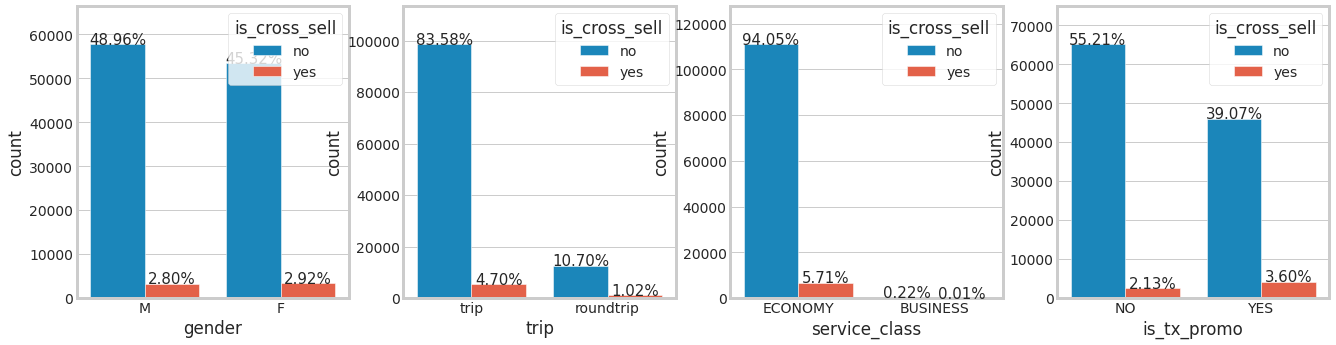

In [25]:
# Plot setting
rcParams['figure.figsize'] = [20,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,4)

# Plot preparation
list_var = ['gender','trip','service_class','is_tx_promo']
total = len(df_train)

# Countplot of categorical variable excludeing airlines_name
for i in range(len(list_var)) :
    sns.countplot(data=df_train, x=list_var[i], hue='is_cross_sell', ax=ax[i])
    sizes = []
    for p in ax[i].patches :
        height = p.get_height()
        sizes.append(height)
        ax[i].text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=15) 
    ax[i].set_ylim(0, max(sizes) * 1.15)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


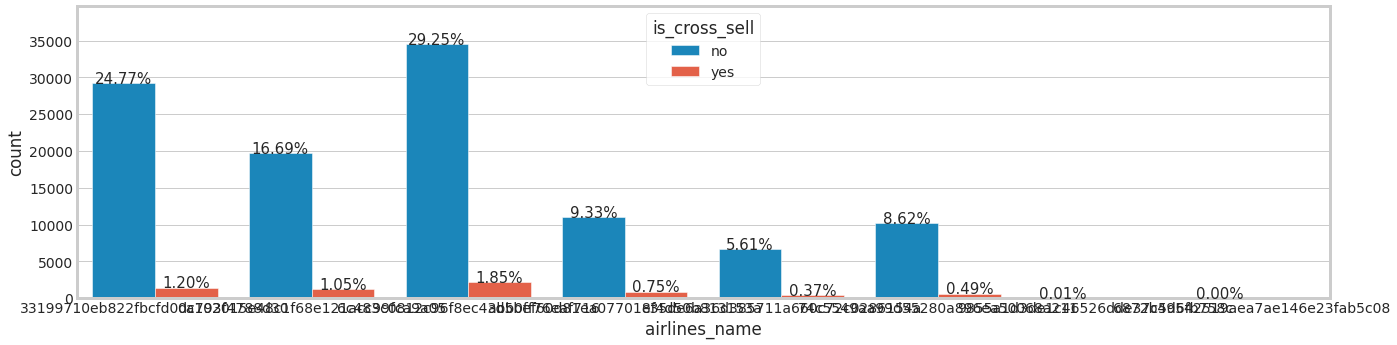

In [26]:
# Plot setting
rcParams['figure.figsize'] = [20,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,1)

# Countplot of airline name
sns.countplot(data=df_train, x='airlines_name', hue='is_cross_sell',ax=ax)
sizes = []

for p in ax.patches :
    height = p.get_height()
    sizes.append(height)
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 
ax.set_ylim(0, max(sizes) * 1.15) ;

From the countplot above we can conclude that :
- Many categorical variable don't give significance impact to the proportion of is_cross_sell=='yes' exceot is_tx_promo. If is_tx_promo=='yes' the proportion is 3.6% higher than is_tx_promo=='no'
- There are categorical variable that have an imbalance proportion as well such as service_class where the proportion of value 'BUSINESS' is only 0.23%

Visually we can't conclude anything so we will use a statsitic test called **Chi Square Test** to quantify the impact of the categorical variable toward response variable is_cross_sell

In [27]:
# Function to do chi square test
def chi_square_test(dfa, var1, var2) :
  # Make contingency table
  df = pd.crosstab(dfa[var1], dfa[var2], margins=False)

  # Calcucalte the statistics measure
  from scipy.stats import chi2_contingency, chi2
  stat, p, dof, expected = chi2_contingency(observed=df
                                         ,correction=True 
                                         ,lambda_=None 
                                          )
  
  # Interprate 
  prob = 0.95
  critical = chi2.ppf(prob, dof)

  if abs(stat) >= critical:
    print(var1,': Dependent')
  else:
    print(var1,': Independent')   
    
# Do it
cat_var = ['gender', 'trip', 'service_class', 'is_tx_promo', 'airlines_name']
for var in cat_var :
  chi_square_test(df_train, var, 'is_cross_sell')

gender : Dependent
trip : Dependent
service_class : Independent
is_tx_promo : Dependent
airlines_name : Dependent


Fromt chi-square test we can conclude that variable service_class is independent from response variable is_cross_sell, so we will drop it

In [0]:
# Drop variable service_class
df_train = df_train.drop(columns=['service_class'])
df_test = df_test.drop(columns=['service_class'])

Next, we will test our previous hypothesis whether if a customer will do a cross-sell can be determined by the number of the seats bought. if a person travels in group, we can guess that it might be a sort of family travelling and this kind of trip has a higher potential to do cross-sell than single travelling. therefore, we will bin the variable [no_of_seats]

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


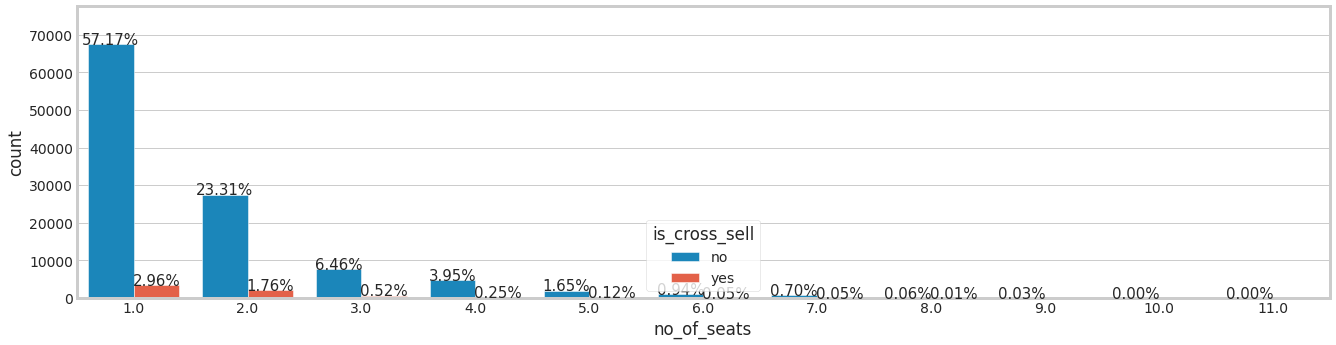

In [29]:
# Plot setting
rcParams['figure.figsize'] = [20,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,1)

# Proportion of no_of_seats using countplot
sns.countplot(data=df_train, x='no_of_seats', hue='is_cross_sell',ax=ax)
sizes = []

for p in ax.patches :
    height = p.get_height()
    sizes.append(height)
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 
ax.set_ylim(0, max(sizes) * 1.15) ;



About 80% of the dataset consists of the 1 or 2 seat's booking, 57% for 1 seat and 23% for a couple of seats. The uncommon number of seat ordered will be on a same group. Next, we will check the proportion of 'is_cross_sell' for every number of seats.


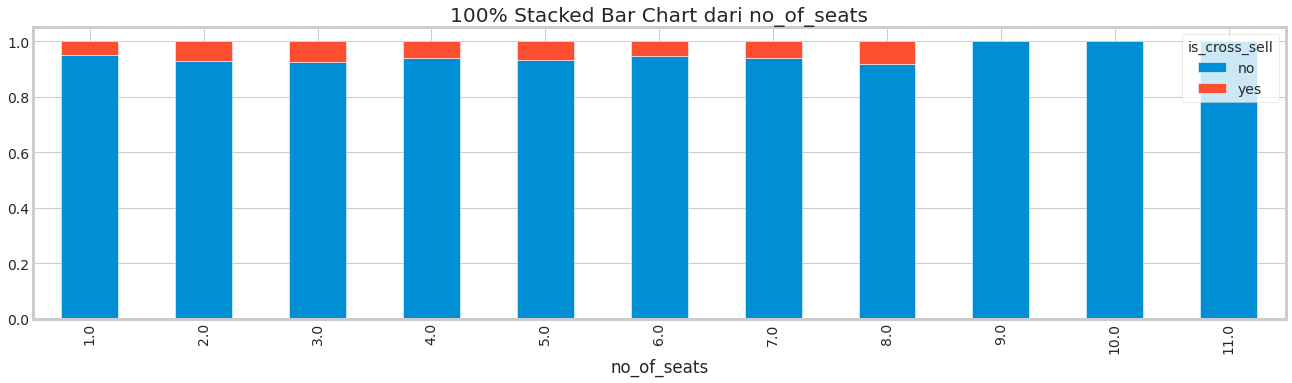

In [30]:
# Plot setting
rcParams['figure.figsize'] = [20,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')

# Plot preparation
df_plot = df_train.groupby(['no_of_seats', 'is_cross_sell'])['account_id'].count() / df_train.groupby('no_of_seats')['account_id'].count()

# Proportion of no_of_seats using 100% stacked bar chart
df_plot.unstack().plot(kind='bar', stacked=True) ;
plt.title('100% Stacked Bar Chart dari no_of_seats') ;

In fact, the one who orders more than 8 seats never do a cross-sell. Therefore, we can create a new group for it. then, we will create a new variable [order_type] with rule:
- number of seats <= 2 : 'Small'
- number of seats >2 and <=8 : 'Big'
- number of seats > 8 : 'Never'

In [0]:
# Function to make variable order_type
def make_order_type(seats) :
    if seats <= 2 :
        order = 'Small'
    elif seats > 2 and seats <= 8 :
        order = 'Big'
    else :
        order = 'Never'
        
    return order

df_train['order_type'] = df_train.apply(lambda x: make_order_type(x['no_of_seats']), axis=1)
df_test['order_type'] = df_test.apply(lambda x: make_order_type(x['no_of_seats']), axis=1)

posx and posy should be finite values
posx and posy should be finite values


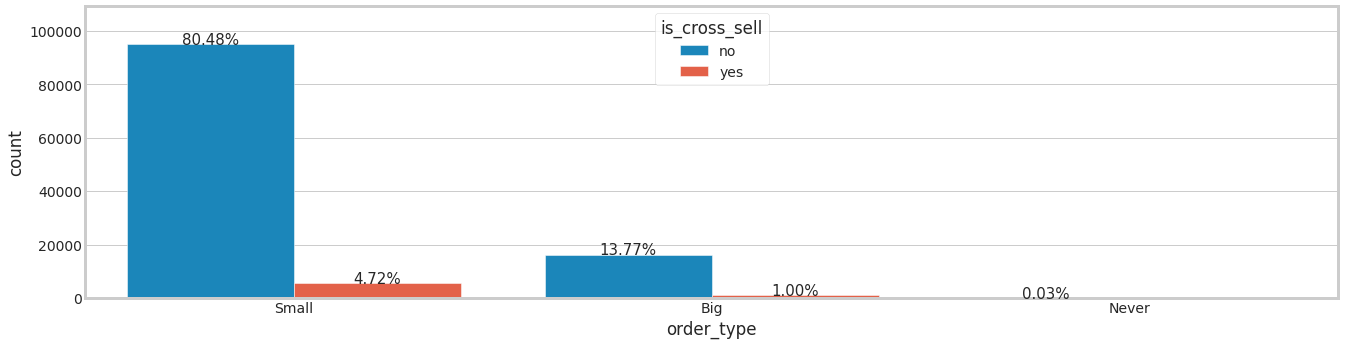

In [32]:
# Plot setting
rcParams['figure.figsize'] = [20,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,1)

# Proportion of order_type using countplot
sns.countplot(data=df_train, x='order_type', hue='is_cross_sell',ax=ax)
sizes = []

for p in ax.patches :
    height = p.get_height()
    sizes.append(height)
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 
ax.set_ylim(0, max(sizes) * 1.15) ;


From the total 5% is_cross_sell == 'Yes', 1% of it comes from order_type=='Big' even only consist of 14% of the observation. so, there a potential about this variable can give a significant effect toward the model. next, we will try to test a new hypothesis about whether a person do a cross-sell it is caused by the kind of promo given. from the previous analysis, we know that promo gives a high impact, but what kind of promo. to determine the type of promo we will use an unsupervised learning called K-means

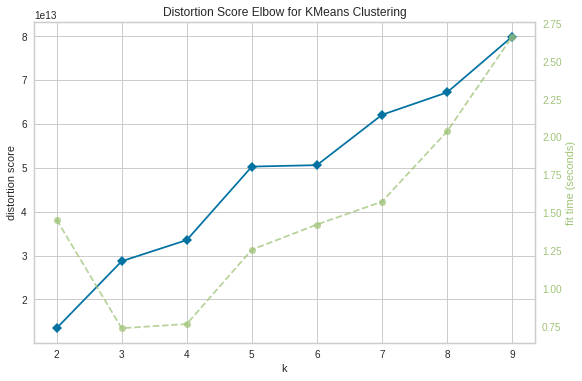

In [33]:
# K-means promo
new_df = df_train[df_train['is_tx_promo']=='YES']

# Change is_cross sell to numeric
new_df['is_cross_sell'] = new_df['is_cross_sell'].replace({'yes':1, 'no':0})

# Initiate list variables
list_var = ['member_duration_days', 'price', 'no_of_seats','mean_transaction', 'median_transaction' ,'total_city', 'is_cross_sell']

# Go
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import KElbowVisualizer
k = 2 

# Make model
algo = KMeans(n_clusters=k, n_init=10, max_iter=300
             ,verbose=0, random_state=11, n_jobs=-1) ;

viz = KElbowVisualizer(model=algo
                      ,k=(2,10)
                      ,metric='distortion'
                      )

# Fitting
viz.fit(new_df[list_var]) ;
viz.poof()

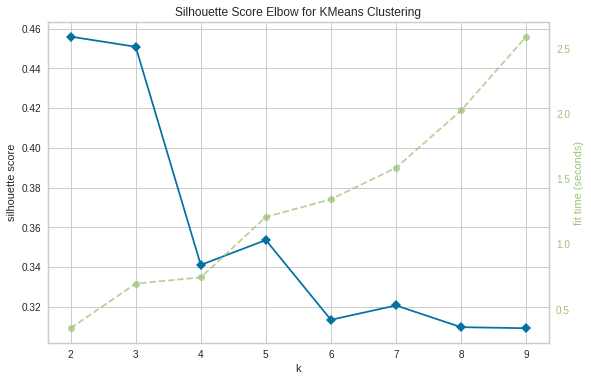

In [34]:
# Silhouette score viz
viz = KElbowVisualizer(model=algo
                      ,k=(2,10)
                      ,metric='silhouette'
                      )

# Fitting
viz.fit(new_df[list_var]) ;
viz.poof()

In [0]:
# Make varaible cat_promo
algo = KMeans(n_clusters=5, n_init=10, max_iter=300
             ,verbose=0, random_state=11, n_jobs=-1) ;
algo.fit(new_df[list_var])

# Go
new_df['cat_promo'] = algo.predict(new_df[list_var]) + 1

# Make dict to replace
dict_replace = new_df[['order_id','cat_promo']].set_index('order_id').to_dict()['cat_promo']

df_train['cat_promo'] = df_train['order_id'].map(dict_replace).fillna(0)

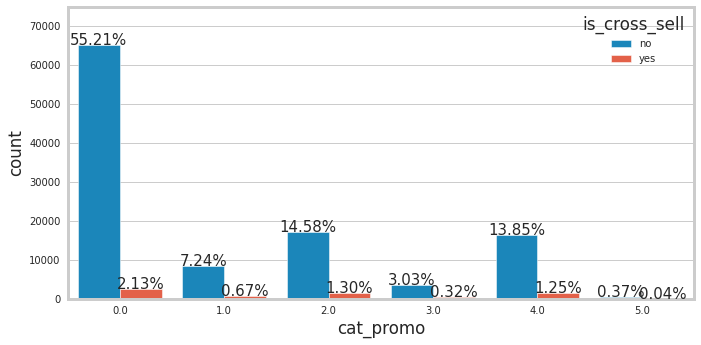

In [36]:
# Plot setting
rcParams['figure.figsize'] = [10,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,1)

# Proportion of cat_promo using countplot
sns.countplot(data=df_train, x='cat_promo', hue='is_cross_sell',ax=ax)
sizes = []

for p in ax.patches :
    height = p.get_height()
    sizes.append(height)
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 
ax.set_ylim(0, max(sizes) * 1.15) ;

## Feature Engineering

In this section, we will create a new variable that might be significantly impact the model based on the analysis from the previous section

We have 4 main continuous variables, that is  **[member_duration_days], [price], [single_price], [median_transaction]** where all of them have a quite skewed distribution and a lot of outliers. to get of it, we will do a logaritmic transformation to these variable

In [0]:
# Make logarihtmic variable
def make_log_var(df) :
    new_df = df.copy()
    new_df['log_member'] = np.log(new_df['member_duration_days'])
    new_df['log_price'] = np.log(new_df['price'])
    new_df['log_single_price'] = np.log(new_df['single_price'])
    new_df['log_transac'] = np.log(new_df['median_transaction'])
    
    return new_df

df_train = make_log_var(df_train)
df_test = make_log_var(df_test)


Next, we will make a binning from continuous variable that we have with decision tree method. The variables which will be used are  **[member_duration_days], [price], [single_price], [median_transaction]**. Will be splited first so that the result of the binning won't overfit with the training dataset. then, we will choose a variable that can give us the best from 'AUC'

In [38]:
# Function to bin using Decision Tree
def check_depth_bin_DT(df, var_to_bin, var_y ) :
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.tree import DecisionTreeClassifier

    # Preparation
    new_df = df[[var_to_bin, var_y]]
    score_ls = []     
    score_std_ls = []

    # Split dataset to avoid overfitting
    x_train, x_test, y_train, y_test = train_test_split(new_df[var_to_bin], new_df[var_y], test_size=0.2
                                                        ,random_state=11, stratify=new_df[var_y])

    # Fitting
    for tree_depth in list(range(1,10)):
        tree_model = DecisionTreeClassifier(max_depth=tree_depth)

        scores = cross_val_score(tree_model, x_train.to_frame(),       
        y_train, cv=3, scoring='roc_auc')   

        score_ls.append(np.mean(scores))

        score_std_ls.append(np.std(scores))

    temp = pd.concat([pd.Series(list(range(1,10))), pd.Series(score_ls), pd.Series(score_std_ls)], axis=1)
    temp.columns = ['depth', 'roc_auc_mean', 'roc_auc_std']
    print(var_to_bin)
    print(temp.iloc[-1,:])
    print('')
    
    
# Go
list_var = ['member_duration_days','price','single_price','median_transaction']
for var in list_var :
    check_depth_bin_DT(df_train, var, 'is_cross_sell')

member_duration_days
depth          9.0000
roc_auc_mean   0.5860
roc_auc_std    0.0067
Name: 8, dtype: float64

price
depth          9.0000
roc_auc_mean   0.5643
roc_auc_std    0.0100
Name: 8, dtype: float64

single_price
depth          9.0000
roc_auc_mean   0.5454
roc_auc_std    0.0055
Name: 8, dtype: float64

median_transaction
depth          9.0000
roc_auc_mean   0.5427
roc_auc_std    0.0037
Name: 8, dtype: float64



We can see that **[member_duration_days] and [price]** give the best score of ROC_AUC. then next, we will check the best depth to do binning using these variables.

In [39]:
# Function bin using Decision Tree
def check_depth_bin_DT(df, var_to_bin, var_y ) :
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.tree import DecisionTreeClassifier

    # Preparation
    new_df = df[[var_to_bin, var_y]]
    score_ls = []     
    score_std_ls = []

    # Split dataset to avoid overfitting
    x_train, x_test, y_train, y_test = train_test_split(new_df[var_to_bin], new_df[var_y], test_size=0.2
                                                        ,random_state=11, stratify=new_df[var_y])

    # Fitting
    for tree_depth in list(range(1,10)):
        tree_model = DecisionTreeClassifier(max_depth=tree_depth)

        scores = cross_val_score(tree_model, x_train.to_frame(),       
        y_train, cv=3, scoring='roc_auc')   

        score_ls.append(np.mean(scores))

        score_std_ls.append(np.std(scores))

    temp = pd.concat([pd.Series(list(range(1,10))), pd.Series(score_ls), pd.Series(score_std_ls)], axis=1)
    temp.columns = ['depth', 'roc_auc_mean', 'roc_auc_std']
    print(var_to_bin)
    print(temp)
    print('')
    
    
# Go
list_var = ['member_duration_days','price']
for var in list_var :
    check_depth_bin_DT(df_train, var, 'is_cross_sell')

member_duration_days
   depth  roc_auc_mean  roc_auc_std
0      1        0.5464       0.0041
1      2        0.5572       0.0077
2      3        0.5657       0.0124
3      4        0.5723       0.0103
4      5        0.5756       0.0127
5      6        0.5833       0.0108
6      7        0.5814       0.0063
7      8        0.5840       0.0091
8      9        0.5860       0.0067

price
   depth  roc_auc_mean  roc_auc_std
0      1        0.5452       0.0019
1      2        0.5493       0.0055
2      3        0.5542       0.0062
3      4        0.5569       0.0022
4      5        0.5581       0.0021
5      6        0.5541       0.0019
6      7        0.5579       0.0038
7      8        0.5632       0.0064
8      9        0.5643       0.0100



From the preceding table, we will choose decision tree with max_depth = 6 for the variabel **[member_duration_days]** and max_depth = 6 for the variable  **[price]** because ROC_AUC_MEAN score before max_depth decrease

In [0]:
# Function to make bin variable
def make_DT_bin(df_train, df_test, max_d, val) :
    
    # Split dataset
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(df_train[val], df_train['is_cross_sell'], test_size=0.2
                                                    ,random_state=11, stratify=df_train['is_cross_sell'])

    # Make the Decision Tree
    from sklearn.tree import DecisionTreeClassifier
    tree_model = DecisionTreeClassifier(max_depth=max_d)
    tree_model.fit(x_train.to_frame(), y_train)

    # Binning
    df_train[val+'_bin'] = tree_model.predict_proba(df_train[val].to_frame())[:,1]
    df_test[val+'_bin'] = tree_model.predict_proba(df_test[val].to_frame())[:,1]

    return df_train, df_test

# Do it
df_train, df_test = make_DT_bin(df_train, df_test, 6, 'member_duration_days')
df_train, df_test = make_DT_bin(df_train, df_test, 5, 'price')

From the previous analysis we get the insight that if the customer ever do the cross sell, he will do it again more likelu. So we will make a few variables to account this behaviour :
- count_hotel : Total cross_sell have been made
- num_occur : How often each customer account doing transaction
- ocf_cross : count_hotel/num_occur represent the probability for each customer acount to do cross-sell

In [0]:
# Make variable num_occur
new_df = pd.concat([df_train.drop(columns=['is_cross_sell']), df_test])
dict_occur = new_df['account_id'].value_counts().to_dict()

df_train['num_occur'] = df_train['account_id'].map(dict_occur)
df_test['num_occur'] = df_test['account_id'].map(dict_occur)

In [0]:
# Function to make count_hotel
def make_count_hotel(df) :

    # Initiate
    new_df = df.copy()
    
    # Count how many cross sell have been made by each account_id 
    dict_replace = df_train[df_train['is_cross_sell']=='yes']['account_id'].value_counts().to_dict()

    # Make the variable
    new_df['count_hotel'] = new_df['account_id'].map(dict_replace)
    new_df['count_hotel'] = new_df['count_hotel'].fillna(0)
    
    return new_df

# Do it
df_train = make_count_hotel(df_train)
df_test = make_count_hotel(df_test)

In [0]:
# Make variable pcg_cross
df_train['pcg_cross'] = df_train['count_hotel'] / df_train['num_occur']
df_test['pcg_cross'] = df_test['count_hotel'] / df_test['num_occur']

From the previous modelling (not in this kernel) we conclude that variable pcg_cross and logarithmic of continuous variable has the highest feature importance. So we will make the interaction between it

In [0]:
# Make interaction variable between pcg_cross and logarithmic of continuous variable
def make_int_pcg(df) :

    # Initiate
    new_df = df.copy()
    
    # Make the variables
    new_df['member_pcg_cross'] = new_df['pcg_cross'] * new_df['log_member']
    new_df['sp_pcg_cross'] = new_df['pcg_cross'] * new_df['log_single_price']
    new_df['price_pcg_cross'] = new_df['pcg_cross'] * new_df['log_price']
    new_df['transac_pcg_cross'] = new_df['pcg_cross'] * new_df['log_transac']
    
    return new_df

# Do it
df_train = make_int_pcg(df_train)
df_test = make_int_pcg(df_test)

Beside the activeness of each account of doing cross sell. We suspect that the type of hotel that have been book from cross sell can give us more information wether the customer will do it again. Because of that we will make new variables derivated from hotel dataset such as :
- mean_star : Average star that have been book for each customer
- free_wifi : Modes of wifi from hotel dataset for each customer
- pool_access : Modes of pool access from hotel dataset for each customer
- free_breakfast : Modes of free breakfast from hotel dataset for each customer

If the customer never done a cross sell before than all of these variable will have a value 'NEVER'

In [0]:
# Function to make derivated variable from hotel dataset
def make_hotel_var(df) :

    # Initiate
    new_df = df.copy()
    
    # Make star variable
    train_hotel = df_train.merge(df_hotel, how='left')
    dict_replace = train_hotel[train_hotel['is_cross_sell']=='yes'].groupby('account_id').agg({'starRating':'mean'}).to_dict()['starRating']
    new_df['mean_star'] = new_df['account_id'].map(dict_replace)
    new_df['mean_star'] = new_df['mean_star'].fillna(0)

    # Make hotel charasteristic variable
    train_hotel = df_train.merge(df_hotel, how='left')
    dict_replace = train_hotel[train_hotel['is_cross_sell']==1].groupby(['account_id'])[['free_wifi','pool_access','free_breakfast']].agg(pd.Series.mode).to_dict()
    for var in dict_replace.keys() :
        new_df[var] = new_df['account_id'].map(dict_replace[var])
        new_df[var] = new_df[var].fillna('NEVER')
        new_df[var] = new_df[var].astype('str').replace({'[]':'NEVER', "['NO' 'YES']":'YES'})
        
    return new_df
        
# Do it
df_train = make_hotel_var(df_train)
df_test = make_hotel_var(df_test)

From previous analysis we get an insight that the total of unique value from variable single_price is only 7% of total rows in the dataset. This seems possible because ticket price of a flight is seldomly change, considering that the dataset only for one route flight only. So will bin variable single_price to reduce the variable variance 

In [0]:
divide = 100000
df_train['single_price'] = (df_train['single_price']/divide).round()*divide
df_test['single_price'] = (df_test['single_price']/divide).round()*divide

# Function to make conv_single_price
def make_conv_price(df) :

    # Initite
    new_df = df.copy()
    
    # Make the variable
    dict_replace = (df_train[df_train['is_cross_sell']==1].groupby('single_price')['account_id'].count() / df_train.groupby('single_price')['account_id'].count()).to_dict()
    new_df['conv_single_price'] = new_df['single_price'].map(dict_replace)
    new_df['conv_single_price'] = new_df['conv_single_price'].fillna(0)
    
    return new_df

# Do it
df_train = make_conv_price(df_train)
df_test = make_conv_price(df_test)

## Modelling
In this section we will make a model to predict is_cross_sell using H2O package. Before it we will split the dataset first so that we have a holdout dataset for cross-validation

In [0]:
# Split the dataset
from sklearn.model_selection import train_test_split
train, valid = train_test_split(df_train, test_size=0.1, stratify=df_train['is_cross_sell'])

In [48]:
# Initiate H2O
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.6" 2020-01-14; OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpo1yt39n9
  JVM stdout: /tmp/tmpo1yt39n9/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpo1yt39n9/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.1.2
H2O cluster version age:,2 days
H2O cluster name:,H2O_from_python_unknownUser_ucmbup
H2O cluster total nodes:,1
H2O cluster free memory:,3 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


In [49]:
# Change dataframe to H2O format
train = h2o.H2OFrame(train)
valid = h2o.H2OFrame(valid)
df_test = h2o.H2OFrame(df_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [51]:
# Initiate variable
X = ['trip','is_tx_promo','no_of_seats','total_city','median_transaction','last_price','order_type'
    ,'log_member','log_price','log_single_price','log_transac','member_duration_days_bin','price_bin','num_occur','count_hotel'
    ,'pcg_cross']
y = 'is_cross_sell'

# Change categorical variable to factor
cat_var = ['trip', 'is_tx_promo','order_type','is_cross_sell']
for var in cat_var :
    train[var] = train[var].asfactor()
    valid[var] = valid[var].asfactor()

# Split training dataset
part_train, part_train_valid, _= train.split_frame(ratios=[0.8,0.1])

# Modelling
list_model = ['DRF','GLM','XGBoost','GBM']
list_train_f1 = []
list_valid_f1 = []
for model in list_model :
    
    from h2o.automl import H2OAutoML
    model_h2o = H2OAutoML(max_models=1
                        ,max_runtime_secs=300
                        ,nfolds=5
                        ,balance_classes=True
                        ,include_algos=[model] 
                        ,keep_cross_validation_predictions=True
                        ,keep_cross_validation_fold_assignment=True
                        ,seed=11
                        ,verbosity='info')
    
    # Train 
    model_h2o.train(x=X, y=y, training_frame=part_train)
    
    # Calculate metricd
    from sklearn.metrics import f1_score
    print(model)
    
    # Train F1
    predict = model_h2o.predict(part_train[X])['predict']
    f1 = f1_score(part_train[y].as_data_frame(), predict.as_data_frame(), pos_label="yes")
    list_train_f1.append(f1)

    # Valid F1
    predict = model_h2o.predict(part_train_valid[X])['predict']
    f1 = f1_score(part_train_valid[y].as_data_frame(), predict.as_data_frame(), pos_label="yes")
    list_valid_f1.append(f1)


AutoML progress: |
00:53:02.773: Project: AutoML_20200320_05302767
00:53:02.774: Setting stopping tolerance adaptively based on the training frame: 0.0034323752070161816
00:53:02.774: Build control seed: 11
00:53:02.774: training frame: Frame key: automl_training_py_10_sid_800a    cols: 39    rows: 84881  chunks: 28    size: 72981429  checksum: -4915858834485135282
00:53:02.774: validation frame: NULL
00:53:02.775: leaderboard frame: NULL
00:53:02.775: blending frame: NULL
00:53:02.775: response column: is_cross_sell
00:53:02.775: fold column: null
00:53:02.775: weights column: null
00:53:02.802: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {StackedEnsemble : defaults}]
00:53:02.825: Disabling Algo: StackedEnsemble as requested by the user.
00:53:02.826: Disabling Algo: XGBoost as requested by the user.
00:53:02.826: Disabling Algo:

In [52]:
# See the result
result = pd.DataFrame({'Model':list_model, 'TrainF1':list_train_f1, 'ValidF1':list_valid_f1})
result

,Model,TrainF1,ValidF1
0,DRF,0.9995,0.7894
1,GLM,0.8578,0.8595
2,XGBoost,0.9169,0.8398
3,GBM,0.8504,0.8285


From the table above we can conclude that XGBoost give the best F1 score on training dataset, but GLM give the best validation F1 score. While the XGBoost give us a solid result (Train F1 = 0.92 and Valid F1 = 0.84), henceforth we will only use GLM and XGBoost. Next we will find the best feature combination for our modelling

In [53]:
# Initiate variable combination
X1 = ['trip','is_tx_promo','no_of_seats','total_city','median_transaction','last_price','order_type'
    ,'log_member','log_price','log_single_price','log_transac','member_duration_days_bin','price_bin','num_occur','count_hotel'
    ,'pcg_cross']
X2 = X1 + ['mean_star','free_wifi','pool_access','free_breakfast','conv_single_price']
X3 = X2 + ['price_pcg_cross']
X4 = X2 + ['member_pcg_cross']
X5 = X2 + ['sp_pcg_cross']
X6 = X2 + ['transac_pcg_cross']
list_x = [X1,X2,X3,X4,X5,X6]
list_x_name = ['X1','X2','X3','X4','X5','X6']

y = 'is_cross_sell'

# Change categorical variable to factor
cat_var = ['trip', 'is_tx_promo','order_type','is_cross_sell','free_wifi','pool_access','free_breakfast']
for var in cat_var :
    train[var] = train[var].asfactor()
    valid[var] = valid[var].asfactor()

# Split dataset
part_train, part_train_valid, _= train.split_frame(ratios=[0.8,0.1])
list_train_f1 = []
list_valid_f1 = []

# Modelling
for i in range(len(list_x)) :
    
    from h2o.automl import H2OAutoML
    model_h2o = H2OAutoML(max_models=5
                        ,max_runtime_secs=300 
                        ,nfolds=5
                        ,balance_classes=True 
                        ,include_algos=['XGBoost', 'GLM']
                        ,keep_cross_validation_predictions=True
                        ,keep_cross_validation_fold_assignment=True
                        ,seed=11
                        ,verbosity='info')
    
    # Train 
    model_h2o.train(x=list_x[i], y=y, training_frame=part_train)
    
    # Calculate train F1
    predict = model_h2o.predict(part_train[list_x[i]])['predict']
    f1 = f1_score(part_train[y].as_data_frame(), predict.as_data_frame(), pos_label="yes")
    list_train_f1.append(f1)

    # Calculate valid F1
    predict = model_h2o.predict(part_train_valid[list_x[i]])['predict']
    f1 = f1_score(part_train_valid[y].as_data_frame(), predict.as_data_frame(), pos_label="yes")
    list_valid_f1.append(f1)
    



AutoML progress: |
01:03:39.482: Project: AutoML_20200320_10339482
01:03:39.482: Setting stopping tolerance adaptively based on the training frame: 0.0034318698499294976
01:03:39.482: Build control seed: 11
01:03:39.483: training frame: Frame key: automl_training_py_1103_sid_800a    cols: 39    rows: 84906  chunks: 28    size: 72415417  checksum: 7157318993320893322
01:03:39.483: validation frame: NULL
01:03:39.483: leaderboard frame: NULL
01:03:39.483: blending frame: NULL
01:03:39.483: response column: is_cross_sell
01:03:39.483: fold column: null
01:03:39.483: weights column: null
01:03:39.483: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {StackedEnsemble : defaults}]
01:03:39.483: Disabling Algo: StackedEnsemble as requested by the user.
01:03:39.483: Disabling Algo: GBM as requested by the user.
01:03:39.483: Disabling Algo: De

In [54]:
# The Result
list_x_name = ['X1','X2','X3','X4','X5','X6']
result = pd.DataFrame({'Var':list_x_name, 'TrainF1':list_train_f1, 'ValidF1':list_valid_f1})
result

,Var,TrainF1,ValidF1
0,X1,0.9166,0.8360
1,X2,0.9194,0.8349
2,X3,0.9227,0.8361
3,X4,0.9228,0.8380
4,X5,0.9231,0.8360
5,X6,0.9199,0.8389


We can see that all of the combination excluding the X1 give a similiar result, but X4 give the best training F1. So we will chose combination X4. Next we will try to remove the outlier from our dataset

In [55]:
# Function to remove outlier using IQR method
def IQR_outlier(df, list_var) :
    # Initiate
    new_df = df.as_data_frame()

    # Make supporting variable
    for var in list_var :
        print('Membersihkan variable',var)
        Q1 = np.percentile(new_df[var], 25)
        Q3 = np.percentile(new_df[var], 75)
        IQR = Q3 - Q1

        # Remove outlier
        count_before = len(new_df)
        bool_bottom = np.array(new_df[var]>(Q1-3*IQR))
        bool_upper = np.array(new_df[var]<(Q3+3*IQR))
        new_df = new_df[bool_bottom & bool_upper]
        print('Berkurang',count_before-len(new_df),'rows')
        print('')

    return h2o.H2OFrame(new_df)

# Do it
train_outlier = IQR_outlier(train, ['price', 'median_transaction', 'single_price','member_duration_days'])

Membersihkan variable price
Berkurang 3784 rows

Membersihkan variable median_transaction
Berkurang 3 rows

Membersihkan variable single_price
Berkurang 210 rows

Membersihkan variable member_duration_days
Berkurang 0 rows

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [57]:
# Modelling
part_train, part_train_valid, _= train_outlier.split_frame(ratios=[0.8,0.1])
list_train_f1 = []
list_valid_f1 = []

from h2o.automl import H2OAutoML
model_h2o = H2OAutoML(max_models=5
                    ,max_runtime_secs=300
                    ,nfolds=5
                    ,balance_classes=True 
                    ,include_algos=['XGBoost', 'GLM']
                    ,keep_cross_validation_predictions=True
                    ,keep_cross_validation_fold_assignment=True
                    ,seed=11
                    ,verbosity='info')

# Change categorical variable to factor
cat_var = ['trip', 'is_tx_promo','order_type','is_cross_sell','free_wifi','pool_access','free_breakfast']
for var in cat_var :
    part_train[var] = part_train[var].asfactor()
    part_train_valid[var] = part_train_valid[var].asfactor()

# Train
model_h2o.train(x=X4, y=y, training_frame=part_train)

# Calculate train F1
predict = model_h2o.predict(part_train[X4])['predict']
f1 = f1_score(part_train[y].as_data_frame(), predict.as_data_frame(), pos_label="yes")
print('Train F1 :',f1)

# Calculate valid F1
predict = model_h2o.predict(part_train_valid[X4])['predict']
f1 = f1_score(part_train_valid[y].as_data_frame(), predict.as_data_frame(), pos_label="yes")
print('Valid F1 :',f1)


AutoML progress: |
01:38:07.230: Project: AutoML_20200320_13807230
01:38:07.234: Setting stopping tolerance adaptively based on the training frame: 0.0034971876433566914
01:38:07.234: Build control seed: 11
01:38:07.234: training frame: Frame key: automl_training_py_4296_sid_800a    cols: 39    rows: 81764  chunks: 26    size: 70283641  checksum: 1569533239994279103
01:38:07.234: validation frame: NULL
01:38:07.234: leaderboard frame: NULL
01:38:07.234: blending frame: NULL
01:38:07.234: response column: is_cross_sell
01:38:07.234: fold column: null
01:38:07.234: weights column: null
01:38:07.234: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {StackedEnsemble : defaults}]
01:38:07.234: Disabling Algo: StackedEnsemble as requested by the user.
01:38:07.234: Disabling Algo: GBM as requested by the user.
01:38:07.234: Disabling Algo: De

Because this is an imbalanced classification, we will try various sampling method including oversampling and undersampling. The fist method that we will try is Tomek Link

In [58]:
### TOMEK LINKS ###

# Split dataset
part_train, part_train_valid, _= train_outlier.split_frame(ratios=[0.8,0.1])
part_train_tl = part_train.as_data_frame()

# Undersampling
from imblearn.under_sampling import TomekLinks
tl = TomekLinks(sampling_strategy='auto', return_indices=True)
X = ['no_of_seats','num_occur','count_hotel','log_price','log_member','log_single_price', 'log_transac'
    ,'total_city','member_duration_days_bin','pcg_cross']
x_res, y_res, idx_res = tl.fit_sample(part_train_tl[X].values, part_train_tl['is_cross_sell'].values)

part_train_tl = h2o.H2OFrame(part_train_tl.iloc[idx_res, :])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [59]:
# Modelling
list_train_f1 = []
list_valid_f1 = []

# Change categorical variable to factor
cat_var = ['trip', 'is_tx_promo','order_type','is_cross_sell','free_wifi','pool_access','free_breakfast']
for var in cat_var :
    part_train_tl[var] = part_train_tl[var].asfactor()
    part_train_valid[var] = part_train_valid[var].asfactor()

from h2o.automl import H2OAutoML
model_h2o = H2OAutoML(max_models=5
                    ,max_runtime_secs=300
                    ,nfolds=5
                    ,balance_classes=True 
                    ,include_algos=['XGBoost', 'GLM']
                    ,keep_cross_validation_predictions=True
                    ,keep_cross_validation_fold_assignment=True
                    ,seed=11
                    ,verbosity='info')

# Train
model_h2o.train(x=X4, y=y, training_frame=part_train_tl)

# Calculate train F1
predict = model_h2o.predict(part_train_tl[X4])['predict']
f1 = f1_score(part_train_tl[y].as_data_frame(), predict.as_data_frame(), pos_label="yes")
print('Train F1 :',f1)

# Calculate valid F1
predict = model_h2o.predict(part_train_valid[X4])['predict']
f1 = f1_score(part_train_valid[y].as_data_frame(), predict.as_data_frame(), pos_label="yes")
print('Valid F1 :',f1)


AutoML progress: |
01:43:31.100: Project: AutoML_20200320_14331100
01:43:31.104: Setting stopping tolerance adaptively based on the training frame: 0.003508707134353889
01:43:31.104: Build control seed: 11
01:43:31.104: training frame: Frame key: automl_training_py_4839_sid_800a    cols: 39    rows: 81228  chunks: 21    size: 68276420  checksum: -2276700314943015084
01:43:31.104: validation frame: NULL
01:43:31.104: leaderboard frame: NULL
01:43:31.104: blending frame: NULL
01:43:31.104: response column: is_cross_sell
01:43:31.104: fold column: null
01:43:31.104: weights column: null
01:43:31.104: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {StackedEnsemble : defaults}]
01:43:31.104: Disabling Algo: StackedEnsemble as requested by the user.
01:43:31.104: Disabling Algo: GBM as requested by the user.
01:43:31.104: Disabling Algo: De

In [60]:
# Undersampling using TomekLinks method on the full training dataset

# Change to pandas DataFrame
train_tl = train_outlier.as_data_frame()

# Do the undersampling
from imblearn.under_sampling import TomekLinks
tl = TomekLinks(sampling_strategy='auto', return_indices=True)
X = ['no_of_seats','num_occur','count_hotel','log_price','log_member','log_single_price', 'log_transac'
    ,'total_city','member_duration_days_bin','pcg_cross']
x_res, y_res, idx_res = tl.fit_sample(train_tl[X].values, train_tl['is_cross_sell'].values)

# Change again to H2OFrame
train_tl = h2o.H2OFrame(train_tl.iloc[idx_res, :])

Parse progress: |█████████████████████████████████████████████████████████| 100%


Next we will try undersampling method called Repeated Edited Nearest Neighbour

In [61]:
### REPEATED EDITED NEAREST NEIGHBOUR ###

# Split the dataset
part_train, part_train_valid, _= train_tl.split_frame(ratios=[0.8,0.1])
part_train_enn = part_train.as_data_frame()

# Do the ndersampling
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
enn = RepeatedEditedNearestNeighbours(return_indices=True)
X = ['no_of_seats','num_occur','count_hotel','log_price','log_member','log_single_price', 'log_transac'
    ,'total_city','member_duration_days_bin','pcg_cross']
x_res, y_res, idx_res = enn.fit_sample(part_train_enn[X].values, part_train_enn['is_cross_sell'].values)

# Change again to H2OFrame
part_train_enn = h2o.H2OFrame(part_train_enn.iloc[idx_res, :])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [62]:
# Modelling
list_train_f1 = []
list_valid_f1 = []

# Change categorical variable to factor
cat_var = ['trip', 'is_tx_promo','order_type','is_cross_sell','free_wifi','pool_access','free_breakfast']
for var in cat_var :
    part_train_enn[var] = part_train_enn[var].asfactor()
    part_train_valid[var] = part_train_valid[var].asfactor()

from h2o.automl import H2OAutoML
model_h2o = H2OAutoML(max_models=5
                    ,max_runtime_secs=300 
                    ,nfolds=5
                    ,balance_classes=True 
                    ,include_algos=['XGBoost', 'GLM']
                    ,keep_cross_validation_predictions=True
                    ,keep_cross_validation_fold_assignment=True
                    ,seed=11
                    ,verbosity='info')

# Train
model_h2o.train(x=X4, y=y, training_frame=part_train_enn)

# Calculate train F1
predict = model_h2o.predict(part_train_enn[X4])['predict']
f1 = f1_score(part_train_enn[y].as_data_frame(), predict.as_data_frame(), pos_label="yes")
print('Train F1 :',f1)

# Calculate valid F1
predict = model_h2o.predict(part_train_valid[X4])['predict']
f1 = f1_score(part_train_valid[y].as_data_frame(), predict.as_data_frame(), pos_label="yes")
print('Valid F1 :',f1)


AutoML progress: |
01:49:47.48: Project: AutoML_20200320_14947048
01:49:47.51: Setting stopping tolerance adaptively based on the training frame: 0.0035449627526073597
01:49:47.51: Build control seed: 11
01:49:47.51: training frame: Frame key: automl_training_py_5392_sid_800a    cols: 39    rows: 79575  chunks: 21    size: 67718761  checksum: 7400788542609002657
01:49:47.51: validation frame: NULL
01:49:47.51: leaderboard frame: NULL
01:49:47.51: blending frame: NULL
01:49:47.51: response column: is_cross_sell
01:49:47.51: fold column: null
01:49:47.51: weights column: null
01:49:47.51: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {StackedEnsemble : defaults}]
01:49:47.52: Disabling Algo: StackedEnsemble as requested by the user.
01:49:47.52: Disabling Algo: GBM as requested by the user.
01:49:47.52: Disabling Algo: DeepLearning as 

In [63]:
# Undersampling using RepeatedEditedNearestNeighbour method on the full training dataset

# Change to pandas DataFrame
train_enn = train_tl.as_data_frame()

# Do the undersampling
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
enn = RepeatedEditedNearestNeighbours(return_indices=True)
X = ['no_of_seats','num_occur','count_hotel','log_price','log_member','log_single_price', 'log_transac'
    ,'total_city','member_duration_days_bin','pcg_cross']
x_res, y_res, idx_res = enn.fit_sample(train_enn[X].values, train_enn['is_cross_sell'].values)

# Change to H2OFrame
train_enn = h2o.H2OFrame(train_enn.iloc[idx_res, :])

Parse progress: |█████████████████████████████████████████████████████████| 100%


Lastly we will use oversampling method called SMOTENC

In [64]:
### SMOTENC ###

# Split the dataset
part_train, part_train_valid, _= train_enn.split_frame(ratios=[0.8,0.1])
part_train_sm = part_train.as_data_frame()

# Do the oversampling
from imblearn.over_sampling import SMOTENC
col_to_drop = ['account_id','order_id','log_transaction','gender','airlines_name','route','hotel_id','visited_city']
part_train_sm = part_train_sm.drop(columns=col_to_drop)
X = list(part_train_sm.drop(columns=['is_cross_sell']).columns)
cat_idx = h2o.H2OFrame(part_train_sm[X]).columns_by_type('categorical')
cat_idx = list(pd.Series(cat_idx).astype('int'))
sm = SMOTENC(categorical_features=cat_idx)
x_res, y_res = sm.fit_resample(part_train_sm[X], part_train_sm['is_cross_sell'])

# Make it in to a DataFrme again
x_res = pd.DataFrame(x_res, columns=X)
y_res = pd.DataFrame(y_res, columns=['is_cross_sell'])
part_train_sm = pd.concat([x_res, y_res], axis=1)

# Change to H2OFrame
part_train_sm = h2o.H2OFrame(part_train_sm)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [65]:
# Modelling
list_train_f1 = []
list_valid_f1 = []

# Change categorical variable to factor
cat_var = ['trip', 'is_tx_promo','order_type','is_cross_sell','free_wifi','pool_access','free_breakfast']
for var in cat_var :
    part_train_sm[var] = part_train_sm[var].asfactor()
    part_train_valid[var] = part_train_valid[var].asfactor()

from h2o.automl import H2OAutoML
model_h2o = H2OAutoML(max_models=5
                    ,max_runtime_secs=300 #Waktu yang dibutuhkan sampai membuat stacked model
                    ,nfolds=5
                    ,balance_classes=True #Enabe pada kasus imbalance classification
                    ,include_algos=['XGBoost', 'GLM']
                    ,keep_cross_validation_predictions=True
                    ,keep_cross_validation_fold_assignment=True
                    ,seed=11
                    ,verbosity='info')

# Train
model_h2o.train(x=X4, y=y, training_frame=part_train_sm)

# Calculate train F1
predict = model_h2o.predict(part_train_sm[X4])['predict']
f1 = f1_score(part_train_sm[y].as_data_frame(), predict.as_data_frame(), pos_label="yes")
print('Train F1 :',f1)

# Calculate valid F1
predict = model_h2o.predict(part_train_valid[X4])['predict']
f1 = f1_score(part_train_valid[y].as_data_frame(), predict.as_data_frame(), pos_label="yes")
print('Valid F1 :',f1)


AutoML progress: |
01:58:18.341: Project: AutoML_20200320_15818341
01:58:18.350: Setting stopping tolerance adaptively based on the training frame: 0.002583815439321714
01:58:18.350: Build control seed: 11
01:58:18.350: training frame: Frame key: automl_training_py_5938_sid_800a    cols: 31    rows: 149788  chunks: 13    size: 19210374  checksum: -660545778664605776
01:58:18.350: validation frame: NULL
01:58:18.350: leaderboard frame: NULL
01:58:18.350: blending frame: NULL
01:58:18.350: response column: is_cross_sell
01:58:18.350: fold column: null
01:58:18.350: weights column: null
01:58:18.350: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {StackedEnsemble : defaults}]
01:58:18.350: Disabling Algo: StackedEnsemble as requested by the user.
01:58:18.350: Disabling Algo: GBM as requested by the user.
01:58:18.350: Disabling Algo: De

In [66]:
# Oversampling using SMOTENC method on the full training dataset

# Change to pandas DataFrame
train_sm = train_tl.as_data_frame()

# Do the oversampling
from imblearn.over_sampling import SMOTENC
col_to_drop = ['account_id','order_id','log_transaction','gender','airlines_name','route','hotel_id','visited_city']
train_sm = train_sm.drop(columns=col_to_drop)
X = list(train_sm.drop(columns=['is_cross_sell']).columns)
cat_idx = h2o.H2OFrame(train_sm[X]).columns_by_type('categorical')
cat_idx = list(pd.Series(cat_idx).astype('int'))
sm = SMOTENC(categorical_features=cat_idx)
x_res, y_res = sm.fit_resample(train_sm[X], train_sm['is_cross_sell'])

# Change to DataFrame again
x_res = pd.DataFrame(x_res, columns=X)
y_res = pd.DataFrame(y_res, columns=['is_cross_sell'])
train_sm = pd.concat([x_res, y_res], axis=1)

# Change to H2OFrame
train_sm = h2o.H2OFrame(train_sm)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [67]:
# Change categorical variable to factor
cat_var = ['trip', 'is_tx_promo','order_type','is_cross_sell','free_wifi','pool_access','free_breakfast']
for var in cat_var :
    train_sm[var] = train_sm[var].asfactor()
    valid[var] = valid[var].asfactor()

# Make the best XGBoost model
from h2o.automl import H2OAutoML
model_h2o = H2OAutoML(max_models=5
                    ,max_runtime_secs=600
                    ,nfolds=5
                    ,balance_classes=True 
                    ,include_algos=['XGBoost']
                    ,keep_cross_validation_predictions=True
                    ,keep_cross_validation_fold_assignment=True
                    ,seed=11
                    ,verbosity='info')

# Train 
model_h2o.train(x=X4, y=y, training_frame=train_sm)

# Calculate train F1
predict = model_h2o.predict(train_sm[X4])['predict']
f1 = f1_score(train_sm[y].as_data_frame(), predict.as_data_frame(), pos_label="yes")
print('Train F1 :',f1)

# Calculate ultimate valid F1 (Validation dataset split before all the preprocessing)
predict = model_h2o.predict(valid[X4])['predict']
f1 = f1_score(valid[y].as_data_frame(), predict.as_data_frame(), pos_label="yes")
print('Ultimate Valid F1 :',f1)

# Take the best model
lb = model_h2o.leaderboard
m = h2o.get_model(lb[0, 'model_id'])

# Take the params
first_param = m.params
first_param.pop('training_frame', None)
first_param.pop('validation_frame', None)
first_param.pop('response_column', None)
first_param.pop('model_id', None)
first_param = {k:first_param[k]['actual'] for k in first_param.keys()}
first_param['nfolds'] = 3
first_param['keep_cross_validation_predictions'] = True
first_param['fold_assignment'] = 'Modulo'

AutoML progress: |
02:06:10.374: Project: AutoML_20200320_20610374
02:06:10.379: Setting stopping tolerance adaptively based on the training frame: 0.002285333739371154
02:06:10.379: Build control seed: 11
02:06:10.379: training frame: Frame key: automl_training_py_6456_sid_800a    cols: 31    rows: 191470  chunks: 17    size: 25869948  checksum: -1263522788297501912
02:06:10.379: validation frame: NULL
02:06:10.379: leaderboard frame: NULL
02:06:10.379: blending frame: NULL
02:06:10.379: response column: is_cross_sell
02:06:10.379: fold column: null
02:06:10.379: weights column: null
02:06:10.380: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {StackedEnsemble : defaults}]
02:06:10.380: Disabling Algo: StackedEnsemble as requested by the user.
02:06:10.380: Disabling Algo: GLM as requested by the user.
02:06:10.380: Disabling Algo: G

In [68]:
# See the leaderboard
lb

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
XGBoost_1_AutoML_20200320_020610,0.999759,0.0204179,0.901849,0.00775578,0.075728,0.00573474


Next we will make 6 XGBoost model using all the variable combination we had. Then we will make a stacking ensemble model using all 6

In [70]:

# Define variable combination
X1 = ['trip','is_tx_promo','no_of_seats','total_city','median_transaction','last_price','order_type'
    ,'log_member','log_price','log_single_price','log_transac','member_duration_days_bin','price_bin','num_occur','count_hotel'
    ,'pcg_cross']
X2 = X1 + ['mean_star','free_wifi','pool_access','free_breakfast','conv_single_price']
X3 = X2 + ['price_pcg_cross']
X4 = X2 + ['member_pcg_cross']
X5 = X2 + ['sp_pcg_cross']
X6 = X2 + ['transac_pcg_cross']
list_x = [X1,X2,X3,X4,X5,X6]
list_x_name = ['X1','X2','X3','X4','X5','X6']

# Define dictionary to save all the params
dict_param = {}
for i in range(len(list_x)) :
  
  # Initiate
    now_X = list_x[i]
    iter = 1
    train_f1 = []
    test_f1 = []
    valid_f1 = []

    for j in range(iter) :

        from h2o.automl import H2OAutoML
        model_h2o = H2OAutoML(max_models=1
                            ,max_runtime_secs=300 #Waktu yang dibutuhkan sampai membuat stacked model
                            ,nfolds=3
                            ,balance_classes=True #Enabe pada kasus imbalance classification
                            ,include_algos=['XGBoost'] #Dapat dispesifikasiin
                            ,keep_cross_validation_predictions=True
                            ,keep_cross_validation_fold_assignment=True
                            ,seed=11
                            ,verbosity='info')


        # Train
        model_h2o.train(x=now_X, y=y, training_frame=train_sm)

        # Take the best model
        lb = model_h2o.leaderboard
        m = h2o.get_model(lb[0, 'model_id'])

        # Take the params
        param = m.params
        param.pop('training_frame', None)
        param.pop('validation_frame', None)
        param.pop('response_column', None)
        param.pop('model_id', None)
        param = {k:param[k]['actual'] for k in param.keys()}
        param['nfolds'] = 3
        param['keep_cross_validation_predictions'] = True
        param['fold_assignment'] = 'Modulo'

        # Save the params
        dict_param['model'+str(i)] = param

AutoML progress: |
02:31:53.152: Project: AutoML_20200320_23153151
02:31:53.153: Setting stopping tolerance adaptively based on the training frame: 0.002285333739371154
02:31:53.153: Build control seed: 11
02:31:53.153: training frame: Frame key: automl_training_py_6456_sid_800a    cols: 31    rows: 191470  chunks: 17    size: 25869948  checksum: -1263522788297501912
02:31:53.153: validation frame: NULL
02:31:53.153: leaderboard frame: NULL
02:31:53.153: blending frame: NULL
02:31:53.153: response column: is_cross_sell
02:31:53.153: fold column: null
02:31:53.153: weights column: null
02:31:53.154: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {StackedEnsemble : defaults}]
02:31:53.154: Disabling Algo: StackedEnsemble as requested by the user.
02:31:53.154: Disabling Algo: GLM as requested by the user.
02:31:53.154: Disabling Algo: G

In [71]:
### MAKE THE STACKING ENSEMBLE MODEL ###

full_X = list(set(np.sum(pd.Series(list_x))))
dict_model = {}

for i in range(len(dict_param)) :

    # Define the model params
    param = dict_param['model'+str(i)]

    # Make the model
    from h2o.estimators import H2OXGBoostEstimator
    model = H2OXGBoostEstimator(**param)

    # Train modelnya
    model.train(y=y, training_frame=train_sm)

    # Simpan modelnya
    dict_model['model_no'+str(i)] = model
    
# Define the stacked ensemble model
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
ensemble = H2OStackedEnsembleEstimator(base_models=list(dict_model.values()))
ensemble.train(x=full_X, y=y, training_frame=train_sm)

# Calculate the train F1
predict = ensemble.predict(train_sm[full_X])['predict']
f1 = f1_score(train_sm[y].as_data_frame(), predict.as_data_frame(), pos_label="yes")
print('Train F1 :',f1)

# Calculate ultimate valid F1 (Validation dataset split before all the preprocessing)
predict = ensemble.predict(valid[full_X])['predict']
f1 = f1_score(valid[y].as_data_frame(), predict.as_data_frame(), pos_label="yes")
print('Ultimate Valid F1 :',f1)

xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
stackedensemble Model Build progress: |███████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%
Train F1 : 0.9945612706042162
stackedensemble prediction progress: |████████████████████████████████████| 100%
Ultimate Valid F1 : 0.8370106761565838


## Validation
In this section we will evaluate the performance of our model using th holdout dataset. There are two model that we will evaluate :
- Single model XGBoost
- 6-XGBoost Stacking Model

In [0]:
def IQR_outlier(df, list_var) :

    # Initiate the data
    new_df = df.copy()

    # Clean the variable
    for var in list_var :
        print('Membersihkan variable',var)
        Q1 = np.percentile(new_df[var], 25)
        Q3 = np.percentile(new_df[var], 75)
        IQR = Q3 - Q1

        # Drop the outlier
        count_before = len(new_df)
        bool_bottom = np.array(new_df[var]>(Q1-3*IQR))
        bool_upper = np.array(new_df[var]<(Q3+3*IQR))
        new_df = new_df[bool_bottom & bool_upper]
        print('Berkurang',count_before-len(new_df),'rows')
        print('')

    return h2o.H2OFrame(new_df)

def preprocessing_for_modelling(df_train) :

    # Split data
    from sklearn.model_selection import train_test_split
    train, valid = train_test_split(df_train, test_size=0.1, stratify=df_train['is_cross_sell'])
    valid = h2o.H2OFrame(valid)
    
    # Remove outlier
    train = IQR_outlier(train, ['price', 'median_transaction', 'single_price','member_duration_days'])
    
    # Undersampling TomekLinks
    train = train.as_data_frame()
    from imblearn.under_sampling import TomekLinks
    tl = TomekLinks(sampling_strategy='auto', return_indices=True)
    X = ['no_of_seats','num_occur','count_hotel','log_price','log_member','log_single_price', 'log_transac'
        ,'total_city','member_duration_days_bin','pcg_cross']
    x_res, y_res, idx_res = tl.fit_sample(train[X].values, train['is_cross_sell'].values)
    train = h2o.H2OFrame(train.iloc[idx_res, :])
    
    # Undersampling RepeatedEditedNearestNeighbours
    train = train.as_data_frame()
    from imblearn.under_sampling import RepeatedEditedNearestNeighbours
    enn = RepeatedEditedNearestNeighbours(return_indices=True)
    X = ['no_of_seats','num_occur','count_hotel','log_price','log_member','log_single_price', 'log_transac'
        ,'total_city','member_duration_days_bin','pcg_cross']
    x_res, y_res, idx_res = enn.fit_sample(train[X].values, train['is_cross_sell'].values)
    train = h2o.H2OFrame(train.iloc[idx_res, :])
    
    # Oversampling SMOTENC
    train = train.as_data_frame()
    from imblearn.over_sampling import SMOTENC
    col_to_drop = ['account_id','order_id','log_transaction','gender','airlines_name','route','hotel_id','visited_city']
    train = train.drop(columns=col_to_drop)
    X = list(train.drop(columns=['is_cross_sell']).columns)
    cat_idx = h2o.H2OFrame(train[X]).columns_by_type('categorical')
    cat_idx = list(pd.Series(cat_idx).astype('int'))
    sm = SMOTENC(categorical_features=cat_idx)
    x_res, y_res = sm.fit_resample(train[X], train['is_cross_sell'])
    
    x_res = pd.DataFrame(x_res, columns=X)
    y_res = pd.DataFrame(y_res, columns=['is_cross_sell'])
    train = pd.concat([x_res, y_res], axis=1)
    train = h2o.H2OFrame(train)
    
    return train, valid

def make_ensemble_model(dict_param, list_x, y, train) :

    # Initiate variable
    full_X = list(set(np.sum(pd.Series(list_x))))
    dict_model = {}

    for i in range(len(dict_param)) :

        # Define the model params
        param = dict_param['model'+str(i)]

        # Define the model
        from h2o.estimators import H2OXGBoostEstimator
        model = H2OXGBoostEstimator(**param)

        # Train model
        model.train(y=y, training_frame=train)

        # Save the model
        dict_model['model_no'+str(i)] = model

    # Make the stacked ensemble model
    from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
    ensemble = H2OStackedEnsembleEstimator(base_models=list(dict_model.values()))
    ensemble.train(x=full_X, y=y, training_frame=train)
    
    return ensemble

In [73]:
# CV for the single model XGBoost
iter = 1
list_train_f1 = []
list_valid_f1 = []

# Make th model using the previous params
for i in range(iter) :

    # Preprocess the data
    train, valid = preprocessing_for_modelling(df_train)
    
    # Define the model
    from h2o.estimators import H2OXGBoostEstimator
    model = H2OXGBoostEstimator(**first_param)

    # Train model
    model.train(y=y, training_frame=train)
    
    # Calculate train F1
    predict = model.predict(train[X1])['predict']
    f1 = f1_score(train[y].as_data_frame(), predict.as_data_frame(), pos_label="yes")
    list_train_f1.append(f1)

    # Calculate valid F1
    predict = model.predict(valid[X1])['predict']
    f1 = f1_score(valid[y].as_data_frame(), predict.as_data_frame(), pos_label="yes")
    list_valid_f1.append(f1)
    
# See the result
print('Train F1 :',np.mean(list_train_f1))
print('Ultimate Valid F1 :',np.mean(list_valid_f1))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Membersihkan variable price
Berkurang 3808 rows

Membersihkan variable median_transaction
Berkurang 3 rows

Membersihkan variable single_price
Berkurang 224 rows

Membersihkan variable member_duration_days
Berkurang 0 rows

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%
Train F1 : 0.9901615698431664
Ultimate Valid F1

In [74]:
# CV for the 6-XGBoost Stacked Ensemble model
iter = 1
list_train_f1 = []
list_valid_f1 = []

for i in range(iter) :

    # Preprocess the data
    train, valid = preprocessing_for_modelling(df_train)
    
    # Train model
    ensemble = make_ensemble_model(dict_param, list_x, y, train)
    full_X = list(set(np.sum(pd.Series(list_x))))
    
    # Calculate train F1
    predict = model.predict(train[full_X])['predict']
    f1 = f1_score(train[y].as_data_frame(), predict.as_data_frame(), pos_label="yes")
    list_train_f1.append(f1)

    # Calculate valid F1
    predict = model.predict(valid[full_X])['predict']
    f1 = f1_score(valid[y].as_data_frame(), predict.as_data_frame(), pos_label="yes")
    list_valid_f1.append(f1)
    
# See the result
print('Train F1 :',np.mean(list_train_f1))
print('Ultimate Valid F1 :',np.mean(list_valid_f1))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Membersihkan variable price
Berkurang 3820 rows

Membersihkan variable median_transaction
Berkurang 3 rows

Membersihkan variable single_price
Berkurang 222 rows

Membersihkan variable member_duration_days
Berkurang 0 rows

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%
xgboost Model Build progress: |████████████████